# Случайные леса
__Суммарное количество баллов: 10__

В этом задании вам предстоит реализовать ансамбль деревьев решений, известный как случайный лес, применить его к публичным данным и сравнить его эффективность с ансамблями из самых популярных библиотек.

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
from scipy import stats

random.seed(0)

Реализуем сам Random Forest. Идея очень простая: строим `n` деревьев, а затем берем модальное предсказание. Используйте реализацию дерева из HW3.

#### Параметры конструктора
`n_estimators` - количество используемых для предсказания деревьев.

Остальное - параметры деревьев.

#### Методы
`fit(X, y)` - строит `n_estimators` деревьев по выборке `X`.

`predict(X)` - для каждого элемента выборки `X` возвращает самый частый класс, который предсказывают для него деревья.

In [2]:
def get_probs(x):
    x = np.array(x)
    frequencies = np.asarray(np.unique(x, return_counts=True)).T # [[element, n_elemenets], ...]
    cardinal = len(x)
    return np.array(list(map(lambda info : info[1] / cardinal, frequencies)))                     

def gini(x):
    p = get_probs(x)
    return np.sum(p * (1 - p))
    
def entropy(x):
    p = get_probs(x)
    return - np.sum(p * np.log2(p))

def gain(left_y, right_y, criterion):
    n_left = len(left_y)
    n_right = len(right_y)
    n_total = n_left + n_right
    
    return 1 - (n_right / n_total) * criterion(right_y) - (n_left / n_total) * criterion(left_y)

In [129]:
class DecisionTreeLeaf:
    def __init__(self):
        self.y = None
        self.frequencies = None
        
    def get_probs(self):
        total = sum(f for (_, f) in self.frequencies)
        return {class_name : frequency / total for (class_name, frequency) in self.frequencies}

class DecisionTreeNode(DecisionTreeLeaf):
    def __init__(self, split_dim, split_value, left, right):
        super().__init__()
        self.split_dim = split_dim
        self.split_value = split_value
        self.left = left
        self.right = right
        self.all = None

def get_most_frequent_class(y):
    frequency = sorted(np.transpose(np.unique(np.array(y), return_counts=True)), key=lambda a: a[1])
    return frequency[-1][0], frequency

class DecisionTreeClassifier:
    def __init__(self, criterion="gini", max_depth=None, min_samples_leaf=1):
        self.root = None
        self.criterion = gini if criterion == "gini" else entropy
        self.max_depth = max_depth if max_depth is not None else float("inf")
        self.node_id = 0
        self.min_samples_leaf = min_samples_leaf
        
    def _build_leaf(self, y):
        leaf = DecisionTreeLeaf()
        leaf.y, leaf.frequencies = get_most_frequent_class(y)
        return leaf
        
    def _train(self, X, y, cur_depth):
        cur_node = None
        if cur_depth > self.max_depth or len(X) <= self.min_samples_leaf:
            cur_node = DecisionTreeLeaf()
            cur_node.y, cur_node.frequencies = get_most_frequent_class(y)
            return cur_node
        max_q, best_dim, best_val, best_left_S, best_right_S = float("-inf"), None, None, None, None
        unique_values_per_dim = [np.sort(np.unique(row)) for row in np.transpose(X)]
        
        for dim, unique in enumerate(unique_values_per_dim):
            if len(unique) == 1:
                continue
            
            split_val = unique[len(unique) // 2]
            left_S = [(x, y_dot) for (x, y_dot) in zip(X, y) if x[dim] < split_val]
            right_S = [(x, y_dot) for (x, y_dot) in zip(X, y) if x[dim] >= split_val]
            
            left_X, left_y = zip(*left_S)
            right_X, right_y = zip(*right_S)
                  
            ratio_left = len(left_X) / len(right_X)
            ratio_right = len(right_X) / len(left_X)
            
            q = gain(left_y, right_y, self.criterion)
            if q > max_q:
                max_q = q
                best_dim = dim
                best_val = split_val
                best_left_S = left_S
                best_right_S = right_S
        
        if best_right_S is None or best_left_S is None:
            return self._build_leaf(y)
        
        best_right_X, best_right_y = zip(*best_right_S)
        best_left_X, best_left_y = zip(*best_left_S)
        
        left = self._train(best_left_X, best_left_y, cur_depth + 1)
        right = self._train(best_right_X, best_right_y, cur_depth + 1)
        
        cur_node = DecisionTreeNode(best_dim, best_val, left, right)
        cur_node.y = get_most_frequent_class(y)
        return cur_node
        
    
    def fit(self, X, y):
        X, y = zip(*sorted(zip(X, y)))
        self.root = self._train(X, y, 0)
    
    def predict_proba(self, X):
        return [self._find_leaf(x).get_probs() for x in X]
        
    def _find_leaf(self, x):
        cur_node = self.root
        while isinstance(cur_node, DecisionTreeNode):
            if x[cur_node.split_dim] < cur_node.split_value:
                cur_node = cur_node.left
            else:
                cur_node = cur_node.right
        return cur_node
    
    def predict(self, X):
        proba = self.predict_proba(X)
        return [max(p.keys(), key=lambda k: p[k]) for p in proba]

In [138]:
def cut_columns(X, columns_to_cut, axis=0):
    if isinstance(X, pd.DataFrame):
        return X.drop(columns_to_cut, axis=axis, inplace=False)
    return np.delete(X, columns_to_cut, axis)

def cut_rows(X, y, ratio=0.1):
    idx = random.sample(list(range(len(X))), int(ratio * len(X)))
    if isinstance(X, pd.DataFrame):
        X = X.drop(idx, axis=0)
        y = y.drop(idx, axis=0)
    else:
        X = np.delete(X, idx, 0)
        y = np.delete(y, idx, 0)
    return X, y, idx

class DecisionTreeWrapper:
    def __init__(self, **tree_kwargs):
        self.tree = DecisionTreeClassifier(**tree_kwargs)
        self.removed_columns = []
        self.unseen_samples = []
    
    def predict(self, X):
        X = cut_columns(X, self.removed_columns, 1)
        if isinstance(X, pd.DataFrame):
            X = X.values
        X = X.tolist()
        return self.tree.predict(X)
    
    def fit(self, X, y, max_features="auto", drop_columns=True, drop_rows=True):
        if max_features == "auto":
            max_features = float("inf")
            
        if drop_columns:
            self.removed_columns = random.sample(range(len(X[0])), min(len(X[0]) // 6, max_features))
            X = cut_columns(X, self.removed_columns, 1)
        if drop_rows:
            X, y, self.unseen_samples = cut_rows(X, y)
        if isinstance(X, pd.DataFrame):
            X = X.values
            y = y.values
        X = X.tolist()
        y = y.tolist()
        self.tree.fit(X, y)

In [139]:
class RandomForestClassifier:
    def __init__(self, criterion="gini", max_depth=None, min_samples_leaf=1, max_features="auto", n_estimators=10, drop_columns=True, drop_rows=True):
        self.trees = [DecisionTreeWrapper(criterion=criterion, max_depth=max_depth, min_samples_leaf=min_samples_leaf) for _ in range(n_estimators)]
        self.max_features = max_features
        self.drop_columns = drop_columns
        self.drop_rows = drop_rows
    
    def fit(self, X, y):
        for tree in self.trees:
            tree.fit(copy.copy(X), y, max_features=self.max_features, 
                     drop_columns=self.drop_columns, drop_rows=self.drop_rows)
    
    def predict(self, X):
        predictions = [tree.predict(X) for tree in self.trees]
        return stats.mode(predictions, axis=0).mode[0]

### Задание 3 (2 балла)
Оптимизируйте по `AUC` на кроссвалидации (размер валидационной выборки - 20%) параметры своей реализации `Random Forest`: 

максимальную глубину деревьев из [2, 3, 5, 7, 10], количество деревьев из [5, 10, 20, 30, 50, 100]. 

Постройте `ROC` кривую (и выведите `AUC` и `accuracy`) для лучшего варианта.

Подсказка: можно построить сразу 100 деревьев глубины 10, а потом убирать деревья и
глубину.

In [140]:
def plot_roc_curve(y_test, p_pred):
    positive_samples = sum(1 for y in y_test if y == 0)
    tpr = []
    fpr = []
    for w in np.arange(-0.01, 1.02, 0.01):
        y_pred = [(0 if p.get(0, 0) > w else 1) for p in p_pred]
        tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
        fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
    plt.figure(figsize = (7, 7))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

Часто хочется понимать, насколько большую роль играет тот или иной признак для предсказания класса объекта. Есть различные способы посчитать его важность. Один из простых способов сделать это для Random Forest выглядит так:
1. Посчитать out-of-bag ошибку предсказания `err_oob` (https://en.wikipedia.org/wiki/Out-of-bag_error)
2. Перемешать значения признака `j` у объектов выборки (у каждого из объектов изменится значение признака `j` на какой-то другой)
3. Посчитать out-of-bag ошибку (`err_oob_j`) еще раз.
4. Оценкой важности признака `j` для одного дерева будет разность `err_oob_j - err_oob`, важность для всего леса считается как среднее значение важности по деревьям.

Реализуйте функцию `feature_importance`, которая принимает на вход Random Forest и возвращает массив, в котором содержится важность для каждого признака.

In [153]:
def oob_error(forest, X, y):
    n_samples = len(X)
    predictions = [[] for _ in range(n_samples)]
    for tree in forest.trees:
        for sample_i in tree.unseen_samples:
            predictions[sample_i].append(tree.predict(np.expand_dims(X[sample_i], axis=0))[0])
    return np.mean([np.abs((sum(prediction) / len(predictions) - y_i)) for prediction, y_i in zip(predictions, y)])


def mix_vals(col):
    unique = np.unique(col)
    new_col = [unique[np.random.randint(0, len(unique))] for _ in range(len(col))]
    return new_col

In [166]:
def feature_importance(rfc, X, y):
    oob_err = oob_error(rfc, X, y)
    oob_err_j = []
    dim1, dim2 = X.shape
    for feature in range(dim2):
        X_dot = X.copy().T
        X_dot[feature] = mix_vals(X_dot[feature])
        X_dot = X_dot.T
        oob_err_j.append(oob_error(rfc, X_dot, y))
    return oob_err_j - oob_err
        

def most_important_features(importance, names=None, k=20):
    if names is None:
        names = list(range(len(importance)))
    idicies = np.argsort(importance)[::-1][:k]
    return np.array(names)[idicies]

Протестируйте решение на простом синтетическом наборе данных. В результате должна получиться точность `1.0`, наибольшее значение важности должно быть у признака с индексом `4`, признаки с индексами `2` и `3`  должны быть одинаково важны, а остальные признаки - не важны совсем.

In [167]:
def synthetic_dataset(size):
    X = [(np.random.randint(0, 2), np.random.randint(0, 2), i % 6 == 3, 
          i % 6 == 0, i % 3 == 2, np.random.randint(0, 2)) for i in range(size)]
    y = [i % 3 for i in range(size)]
    return np.array(X), np.array(y)

X, y = synthetic_dataset(1000)
rfc = RandomForestClassifier(n_estimators=10, drop_columns=False)
rfc.fit(X, y)
print("Accuracy:", np.mean(rfc.predict(X) == y))
print("Oob:", oob_error(rfc, X, y))
print("Importance:", feature_importance(rfc, X, y)) 
print("Most important:", most_important_features(feature_importance(rfc, X, y), k=1)) 

Accuracy: 1.0
Oob: 0.998009
Importance: [0.       0.       0.00026  0.000268 0.000294 0.      ]
Most important: [4]


Проверьте, какие признаки важны для датасета spam? (Используйте файлы x_spam_train и y_spam_train)

1. Обучите модель на всех данных из x_spam_train и y_spam_train.
2. Сделайте submit своего решения и получите значение f1_score не менее 0.6

In [168]:
data_folder = 'homework-decision-tree'

X, y = pd.read_csv(f'./{data_folder}/x_spam_train.csv', index_col=False).drop('Id', axis=1), pd.read_csv(f'./{data_folder}/y_spam_train.csv', index_col=False).drop('Id', axis=1).values

X = X.values  
split_ratio = 0.9
ds_size = len(X)
assert len(y) == ds_size

p = int(split_ratio * ds_size)
X_train, y_train = X[:p], y[:p]
X_val, y_val = X[p:], y[p:]

In [169]:
rfc = RandomForestClassifier(max_depth=10, n_estimators=10, criterion="gini", drop_columns=False)
rfc.fit(X_train, y_train)
print("Most important:", most_important_features(feature_importance(rfc, X_train, y_train), k=3)) 

Most important: [ 6 45 24]


In [170]:
# Baseline
tree = DecisionTreeClassifier(max_depth=6)
tree.fit(X_train.tolist(), y_train.tolist())

pred = tree.predict(X_val)
print(f"Accuracy: {np.mean(pred == y_val)}, F-1: {f1_score(y_val, pred)}" )

Accuracy: 0.5165406427221172, F-1: 0.8400000000000001


In [171]:
forest = RandomForestClassifier(max_depth=10, n_estimators=100, criterion="gini")
forest.fit(X_train, y_train)
pred = forest.predict(X_val)
print(f"Accuracy: {np.mean(pred == y_val)}, F-1: {f1_score(y_val, pred)}" )

Accuracy: 0.5181947069943289, F-1: 0.9054054054054054


In [430]:
X_test = pd.read_csv(f'./{data_folder}/x_spam_test.csv', index_col=False)

submission = pd.DataFrame(columns = ["Id", "Expected"])
submission["Id"] = X_test["Id"]

X_test.drop('Id', axis=1, inplace=True)
submission["Expected"] = forest.predict(X_test.values)
submission.to_csv('submission.csv', index=False)

В качестве альтернативы попробуем библиотечные реализации ансамблей моделей. 

1. [CatBoost](https://catboost.ai/docs/)
2. [XGBoost](https://xgboost.readthedocs.io/en/latest/)
3. [LightGBM](https://lightgbm.readthedocs.io/en/latest/)


Установите необходимые библиотеки. 
Возможно, потребуется установка дополнительных пакетов.

In [ ]:
!pip3 install lightgbm
!pip3 install catboost
!pip3 install xgboost

1. Примените модели для нашего датасета.

2. Для стандартного набора параметров у каждой модели нарисуйте `ROC` кривую и выведите `AUC` и `accuracy`.

3. Посчитайте время обучения каждой модели (можно использовать [timeit magic](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-timeit)).

4. Сравните метрики качества и скорость обучения моделей. Какие выводы можно сделать?

Learning rate set to 0.5
0:	learn: 0.3471699	total: 3.44ms	remaining: 13.8ms
1:	learn: 0.2958508	total: 6.89ms	remaining: 10.3ms
2:	learn: 0.2652729	total: 9.39ms	remaining: 6.26ms
3:	learn: 0.2446272	total: 12ms	remaining: 2.99ms
4:	learn: 0.2361664	total: 14.8ms	remaining: 0us


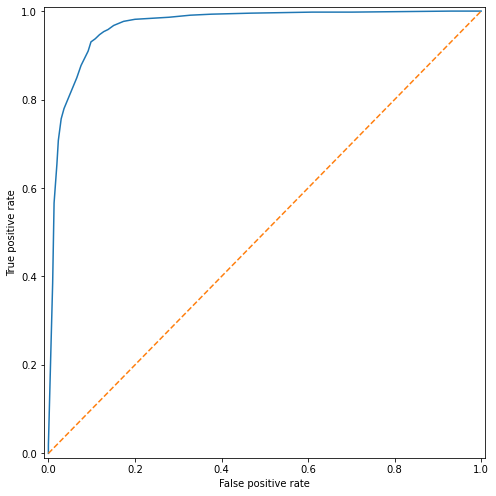

In [38]:
from catboost import CatBoost, Pool

train_pool = Pool(X_train, y_train)
model = CatBoost({'iterations' : 5})
model.fit(train_pool)

p_preds = [{i : p for i, p in enumerate(probs)} for probs in model.predict(X_val, prediction_type='Probability')]
plot_roc_curve(np.squeeze(y_val), p_preds)

In [ ]:
import xgboost as xgb

dtrain = xgb.DMatrix('demo/data/agaricus.txt.train')
dtest = xgb.DMatrix('demo/data/agaricus.txt.test')

_Ваш ответ_